# TensorFlow Tutorial: Word Embeddings

This tutorial is based on [TensorFlow Vector Representations of Words](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

You can find the original code here: [TensorFlow word2vec Basic](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/word2vec).

The code below trains a skip-gram model the [Text8 dataset](http://mattmahoney.net/dc/textdata).

In [4]:
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import urllib
import zipfile
from matplotlib import pylab
from sklearn.manifold import TSNE

**Download data, if necessary:**

In [5]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filedir, filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  filepath = filedir + '/' + filename
  if not os.path.exists(filepath):
    filename, _ = urllib.urlretrieve(url + filename, filepath)
  statinfo = os.stat(filepath)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', filepath
  else:
    print statinfo.st_size
    raise Exception(
      'Failed to verify ' + filepath + '. Can you get to it with a browser?')
  return filepath

filename = maybe_download('data','text8.zip', 31344016)

Found and verified data/text8.zip


**Convert the dataset to a string:**

In [6]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return f.read(name).split()
  f.close()
  
words = read_data(filename)
print 'Data size', len(words)

Data size 17005207


**Build the dictionary and replace rare words with UNK token:**

In [7]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print 'Most common words (+UNK)', count[:5]
print 'Sample data', data[:10]
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


**Construct the training procedure:**

In [8]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size / num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print batch[i], '->', labels[i, 0]
  print reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i, 0]]

3084 -> 12
originated -> as
3084 -> 5239
originated -> anarchism
12 -> 6
as -> a
12 -> 3084
as -> originated
6 -> 12
a -> as
6 -> 195
a -> term
195 -> 6
term -> a
195 -> 2
term -> of


**Train the skip-gram model:**

In [9]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(xrange(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [10]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized"
  average_loss = 0
  for step in xrange(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print "Average loss at step", step, ":", average_loss
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = "%s %s," % (log, close_word)
        print log
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0 : 8.2833108902
Nearest to about: bestselling, maronite, carmelite, eyepiece, anxieties, leaked, adolescent, residents,
Nearest to some: updating, corrode, desu, bloggers, pngimage, strands, nissan, kuomintang,
Nearest to be: stock, homes, irritable, naturalism, refracting, spr, hip, nighthawk,
Nearest to to: offal, mikhailovich, embody, focus, komm, impenetrable, brief, disintegration,
Nearest to may: attempting, study, burman, wayward, scripting, startling, uso, everton,
Nearest to from: futures, circe, location, anacletus, bookshelf, presentations, brave, mangrove,
Nearest to over: fanaticism, tachycardia, chimera, vfr, witte, antigonus, jahn, crews,
Nearest to most: thickly, dram, transliterated, ibizan, narrowed, hypothesis, caesarea, fsm,
Nearest to used: pendants, montezuma, springer, hitchhiker, atheroma, infringed, migration, diverted,
Nearest to so: favoritism, atmosphere, smoker, olds, courtroom, aerodynamic, est, herbert,
Nearest to nine: m

In [11]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

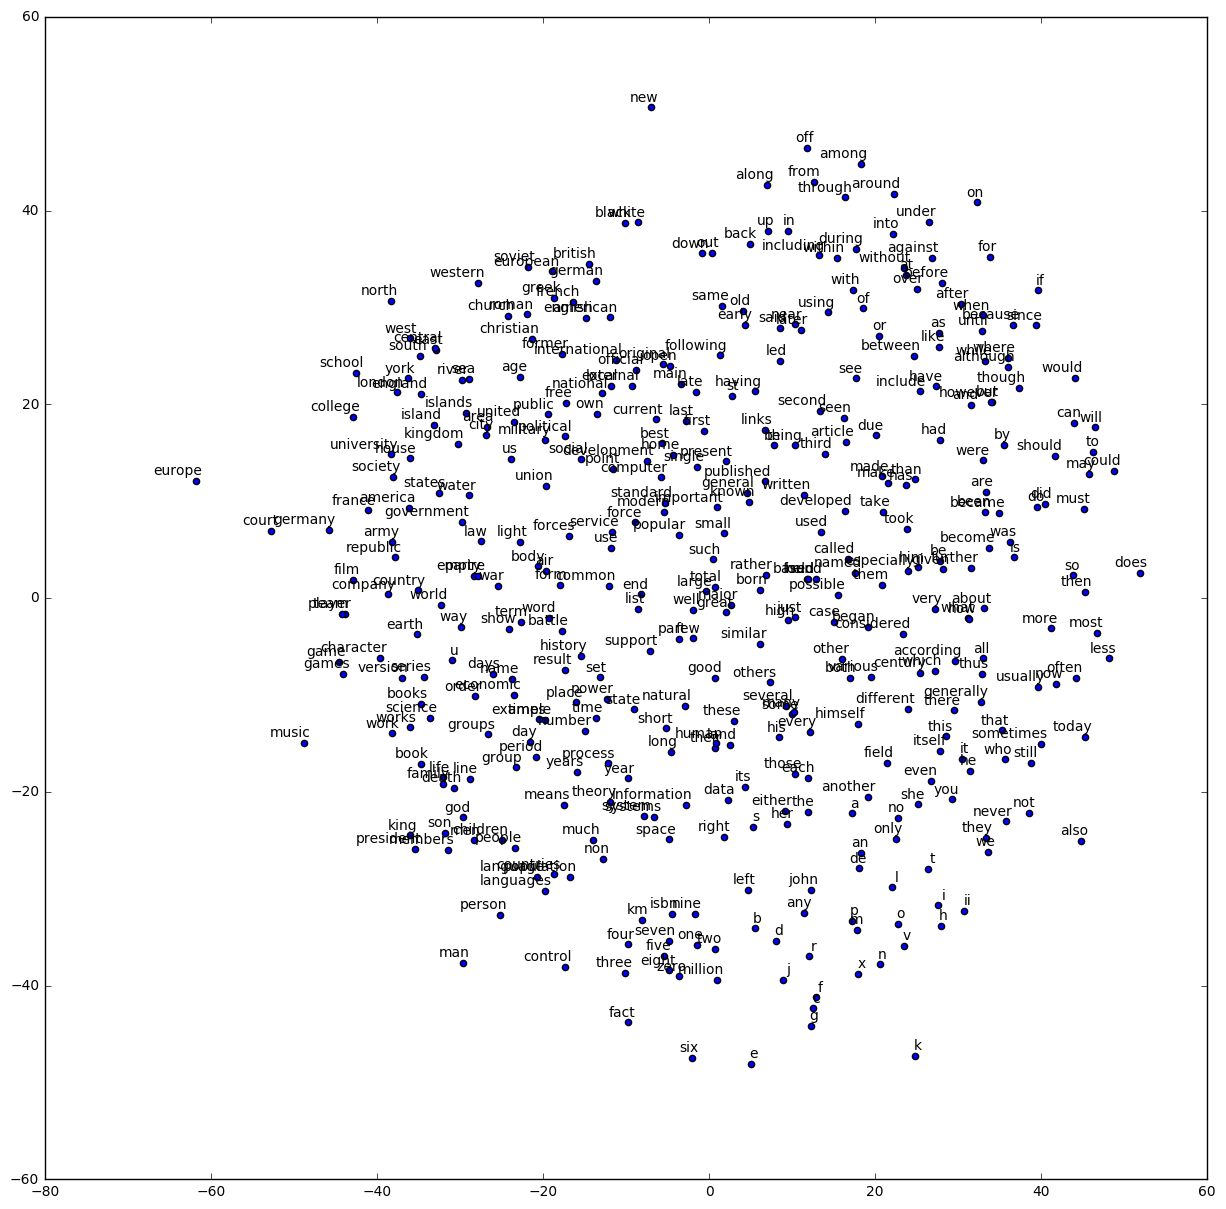

In [12]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in xrange(1, num_points+1)]
plot(two_d_embeddings, words)